## Predicting Good Amazon Reviews based on Word2Vec and Features Interpretation
 
 ** Version for workshop conducted @ Cambridge Innovation Center(2019.3).
 
For this demo, we will be using the [Amazon Fine Food Reviews Data](https://www.kaggle.com/snap/amazon-fine-food-reviews).  The Amazon Fine Food Reviews dataset consists of 568,454 food reviews Amazon users left up to October 2012.

This script is based off of the [Craigslist Word2Vec Demo](https://github.com/h2oai/h2o-3/blob/master/h2o-py/demos/word2vec_craigslistjobtitles.ipynb).

#### Motivation and Goal:  
- Which features will contribute most to a 'positive'/'negative' production? (Helpfulness Denominator, Product, or the review by text etc.?) 
- What keyword in the review will be the top contribution to a 'positive'/'negative' review?
- How could we improve the XGBoosting in this review prediction case?  

#### Workflow:  
<img src='Image/Architecture/arch.PNG'>


## Import Data

We will begin by importing our review data into our H2O cluster.    
In this case, I will be starting up an H2O cluster on my local computer.

In [28]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [29]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [30]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,37 mins 52 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,"14 days, 3 hours and 32 minutes"
H2O cluster name:,H2O_from_python_bear_jpsd3w
H2O cluster total nodes:,1
H2O cluster free memory:,3.128 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [31]:
data_path = "data/AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [32]:
reviews.shape

(55554, 10)

In [33]:
reviews.head()

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats."
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!"
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amounts or much direction. In comparison, the

In [34]:
reviews.describe()

Rows:55554
Cols:10




,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
type,enum,enum,enum,int,int,int,enum,int,int,string
mins,,,,1.0,0.0,3.0,,0.0,944438400.0,NaN
mean,,,,4.185675198905568,2.2578032184901184,284454.8548979371,,1.7664614609209053,1296260730.3596506,NaN
maxs,,,,5.0,878.0,568436.0,,866.0,1351209600.0,NaN
sigma,,,,1.3077531708482195,9.262838990830508,164193.9190660871,,8.638742394580309,47990174.93641191,NaN
zeros,,,,0,26415,0,,29722,0,0
missing,0,0,0,0,0,0,0,0,0,0
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1.0,2.0,41471.0,Evan Eberhardt,2.0,1348358400.0,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3.0,0.0,28582.0,coleridge,0.0,1323907200.0,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
2,B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5.0,0.0,389965.0,Lindsay S. Bradford,0.0,1310601600.0,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"


## Dataset processing by Adding Target Column
- Add Target Column: "PositiveReview" by labeling the good/not good review.
- Note mean score around 4.2:
    - Higher than 4.2: 1
    - Lower than 4.2: 0

In [35]:
reviews["PositiveReview"] = (reviews["Score"] >= 4.2).ifelse("1", "0")

In [36]:
reviews.head()

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats.",1
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.,1
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!",1
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amounts or much di

#### Check the count of 'positive' reviews and 'negative' reviews:  
- Number of Positive reviews: 35448/55554

In [37]:
reviews["PositiveReview"].table()

PositiveReview,Count
0,20106
1,35448


## Train Baseline Model

We will start by training a baseline model that does not use the review and instead uses other attributes in our dataset.

In [38]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [39]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

In [40]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                            stopping_rounds = 5, score_tree_interval = 10,
                                            model_id = "gbm_baseline.hex"
                                           )
gbm_baseline.train(x = predictors, y = response, 
                   training_frame = train, validation_frame = test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [41]:
print("AUC on Validation Data: " + str(round(gbm_baseline.auc(valid = True), 3)))

AUC on Validation Data: 0.595


- We can see that there is a big room for improvement.  Our error is 22%.  
- To improve our model, we will train word embeddings for the review.

In [42]:
gbm_baseline.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48181784133938027: 


,0,1,Error,Rate
0,640.0,3572.0,0.8481,(3572.0/4212.0)
1,237.0,6703.0,0.0341,(237.0/6940.0)
Total,877.0,10275.0,0.3416,(3809.0/11152.0)


The variable importance plot below shows us that the most important variable is `HelpfulnessNumerator`.  Looking at the partial dependency plot for that variable, we see that the more people who find the review helpful, the more likely it is a good review.

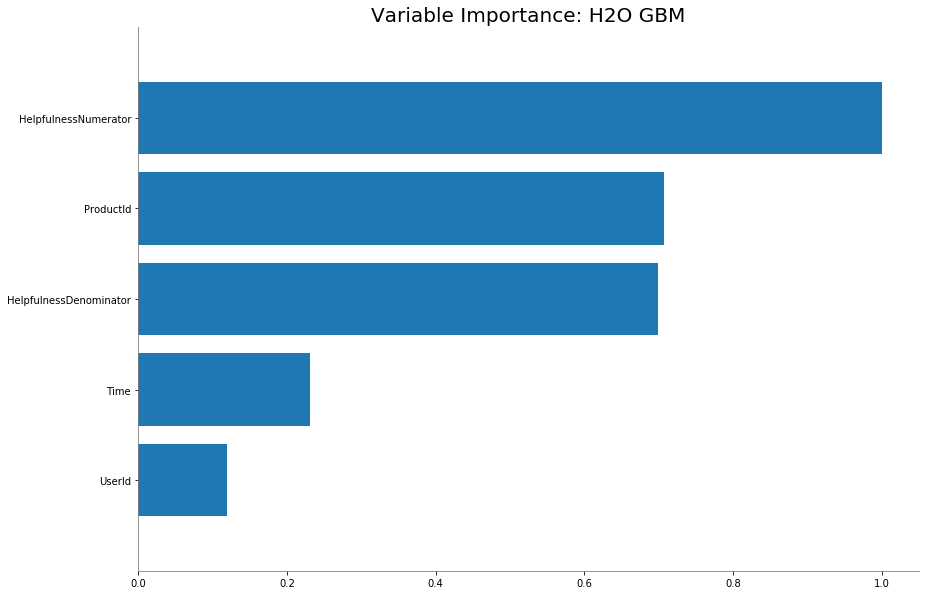

In [43]:
gbm_baseline.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


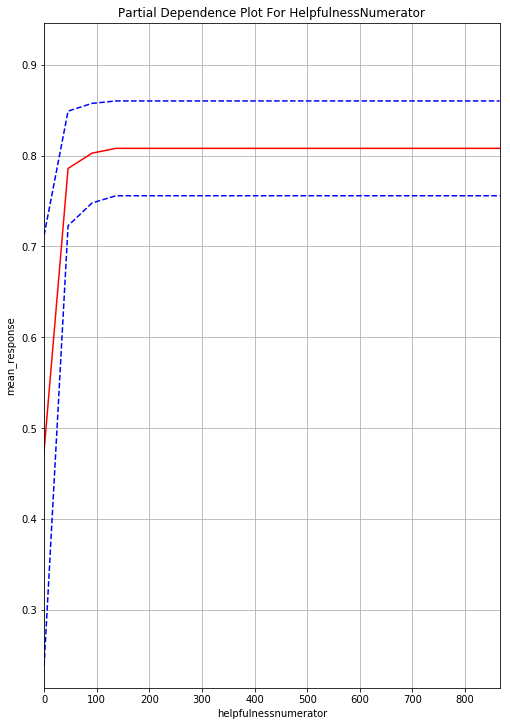

In [44]:
%matplotlib inline  
pdp_helpfulness = gbm_baseline.partial_plot(train, cols = ["HelpfulnessNumerator"])

## Tokenize Words in Review

- Our first step will be to tokenize the words in the review column.   
- We will do this by creating a function called `tokenize`.  This will split the reviews into words and remove any stop words, small words, or words with numbers in them.

In [45]:
data_path = "data/stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [46]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [47]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [48]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


## Train Word2Vec Model

- Now that we've tokenized our words, we can train a word2vec model.  
- We can use the `find_synonms` function to sanity check our word2vec model after training.   

#### Word embedding:  
   - A tech for dimensionality reduction of text data,  
   - It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words.  
   - This model has 300 dimensions and is trained on 3 million words from google news data.   
   - Word Embeddings are Word converted into numbers.  
    
#### Word2Vec:  
   - Word2Vec is one of the most popular word embedding model to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.   
    <img src='Image/embedding.png' style="width: 400px;">

In [51]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

'''
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='data'
h2o.save_model(w2v_model, path = models_path, force = True)
'''
# Pre-trained model built with commented out code
w2v_model = h2o.load_model('data/w2v.hex')

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/bear/Downloads/H2O_Workshop/data/w2v.hex'

- We could get the 'similarity' of 'coffee':  

In [52]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffe', 0.8001018166542053),
             ('coffees', 0.777088463306427),
             ('espresso', 0.7698642611503601),
             ('expresso', 0.751839280128479),
             ('brew', 0.7290859818458557)])

- We could get the 'similarity' of 'stale':

In [53]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('rancid', 0.6621783375740051),
             ('moldy', 0.6204786896705627),
             ('tastless', 0.6153623461723328),
             ('inedible', 0.6086997389793396),
             ('tasteless', 0.5966721773147583)])

- Now that we have a word embedding for each word in our vocabulary,  
- we will aggregate the words for each review using the `transform` function.  This will give us one aggregated word embedding for each review.

In [54]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")

In [55]:
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.0222301,0.0176203,-0.0279962,-0.084383,0.0327319,0.00374433,0.197913,-0.121953,-0.0818958,0.181105,-0.130829,0.0225331,0.0982343,-0.269263,0.0752923,-0.00397764,0.058153,-0.0986002,-0.130923,-0.00244305,0.128551,0.09669,0.0800892,0.118863,0.221607,0.143252,-0.000742175,0.0721932,0.0545797,-0.108448,0.157805,-0.0317655,-0.0581368,0.0848769,-0.0854822,-0.0016789,-0.141238,-0.128868,-0.0390378,-0.187018,-0.0708221,-0.27783,0.0533631,0.083738,-0.136659,0.0566378,-0.149126,-0.0903615,0.0539924,-0.0793402,0.0472095,-0.121374,0.094232,0.0978801,-0.187677,-0.158288,-0.0161498,0.000842189,0.139109,-0.037361,0.0107767,0.213233,-0.0080308,-0.12327,0.00198083,-0.165264,0.0791446,0.0681646,-0.0591774,0.119326,0.120032,-0.1168,0.17495,-0.174366,-0.0418295,-0.0497632,-0.195387,0.187555,-0.168238,0.0203373,0.0633606,-0.0719941,0.0323252,-0.0115341,0.0834494,0.121984,0.123048,0.0936167,-0.00679814,0.0903152,0.000826371,0.103208,0.0490007,-0.0967467,0.0651624,-0.0799558,0.072195,-0.0280295,0.0521706,-0.0532921
0.0611169,0.133818,-0.201674,0.00834379,-0.0862323,-0.00153172,0.0504221,-0.224446,-0.00537116,0.149736,-0.0127867,0.160576,0.0978726,-0.00935735,-0.0549631,-0.0315323,0.220341,-0.158614,-0.100412,0.0139426,0.135478,0.0245681,0.0572641,-0.0633733,-0.00206595,-0.106636,-0.0563827,0.0885715,0.210266,-0.0337932,0.147944,-0.0253914,-0.0283045,0.0384194,-0.0816025,0.246169,-0.127331,-0.0250826,0.042292,-0.214889,-0.212295,0.0608821,0.149036,-0.0522541,-0.180828,-0.00252101,-0.137144,-0.10701,-0.0664093,-0.299048,-0.0486741,-0.0666142,0.154332,0.131855,-0.0321897,-0.0802798,0.0668218,0.1043,-0.0594228,-0.0437347,0.0291499,0.0557701,0.0770354,-0.0270321,-0.09746,-0.1545,0.00903311,-0.106709,0.100127,0.0819011,0.185488,-0.0301543,-0.0632362,-0.229129,0.0736319,-0.057673,-0.162816,0.0780713,-0.0539525,0.0247569,-0.1207,-0.0277206,-0.121361,-0.118566,0.118359,-0.0576456,-0.104987,0.0654967,-0.195398,0.16393,-0.0254775,-0.0730292,0.0697308,-0.0259475,0.0754466,0.0357726,0.00429609,0.0767607,0.120937,0.011578
0.00347578,-0.0293237,-0.0865024,-0.0408858,-0.0711707,-0.0165359,0.210463,0.0106985,-0.0578861,0.112428,-0.120163,0.0729429,-0.0386858,-0.148153,0.0739208,-0.152462,0.199604,-0.0350471,-0.0981175,0.0973254,0.0834576,0.0509911,0.0354068,0.0362996,0.215612,0.0383493,0.0664434,-0.000874205,0.0844223,-0.0768242,0.100933,0.0153598,-0.0943646,-0.0035191,-0.0674301,0.0805501,-0.138866,-0.0779094,0.071009,-0.12787,-0.28707,-0.155372,0.18793,0.0447096,-0.118555,-0.00746909,-0.183486,-0.0503872,-0.0745656,-0.0820548,0.078941,-0.22688,0.082254,0.0769799,-0.117016,-0.00451908,-0.0172991,0.0102254,0.0347135,-0.130931,-0.0700581,0.132149,0.135937,-0.254491,-0.070977,-0.200545,-0.0203446,-0.162523,0.103842,0.0325692,-0.0328937,-0.0543901,0.14653,-0.162749,-0.0382375,0.0149129,-0.0746916,0.0657405,-0.103096,0.0680897,-0.0198874,-0.10805,0.0610927,-0.0401588,-0.0221467,-0.128029,0.106495,0.151055,-0.0312196,0.130613,0.0339489,-0.0157771,0.0321408,-0.0160963,0.156975,0.00575574,-0.0340888,-0.0550141,0.0622331,0.0173993
0.112252,0.0441849,0.0183764,0.0727685,-0.0909036,-0.127034,0.0914171,-0.115991,0.0025972,0.144458,-0.0323798,0.0391548,-0.0289301,-0.10024,0.0893981,-0.0690012,0.192639,-0.110876,-0.122309,0.0996895,-0.0072868,-0.0711208,0.105297,-0.0378824,0.145874,0.0676653,-0.0336644,0.0686962,0.0352556,-0.0412048,0.148785,-0.0497677,-0.102931,0.0398723,-0.262625,0.0921722,-0.106241,0.0435338,-0.00740325,-0.223403,-0.239357,-0.113466,0.164984,0.0747561,-0.176947,-0.0461558,-0.198496,-0.0208244,-0.0163366,0.0273682,0.00518914,-0.219732,0.0205538,0.134504,-0.0412493,-0.091103

In [56]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

## Train GBM Model to Predict Good Review

We will train a GBM model with the same parameters as our baseline gbm.  This time, however, we will add the aggregated word embeddings as predictors. 

In [57]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [58]:
predictors = predictors + review_vecs.names
response = 'PositiveReview'

gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
gbm_embeddings.train(x = predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [59]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))

Baseline AUC: 0.595
With Embeddings AUC: 0.81


In [60]:
gbm_embeddings.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.479013219395892: 


,0,1,Error,Rate
0,2133.0,2079.0,0.4936,(2079.0/4212.0)
1,676.0,6264.0,0.0974,(676.0/6940.0)
Total,2809.0,8343.0,0.247,(2755.0/11152.0)


## Adding Summary

We saw that the review column is not the only column with text.  We also have a column called `Summary` which summarizes the review.  We will add the word embeddings of the summary to see if this improves our model.

In [61]:
# Break summaries into sequence of words
summary_words = tokenize(reviews["Summary"].ascharacter())

In [62]:
# Add aggregated summary word embeddings
summary_vecs = w2v_model.transform(summary_words, aggregate_method = "AVERAGE")
summary_vecs.names = ["summary_" + s for s in summary_vecs.names]

ext_reviews = ext_reviews.cbind(summary_vecs)

In [63]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [64]:
predictors = predictors + summary_vecs.names
response = 'PositiveReview'

gbm_plus_summary = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_plus_summary.hex"
                                             )
gbm_plus_summary.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [65]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))
print("With Summary and Review Embeddings AUC: " + str(round(gbm_plus_summary.auc(valid = True), 3)))

Baseline AUC: 0.595
With Embeddings AUC: 0.81
With Summary and Review Embeddings AUC: 0.849


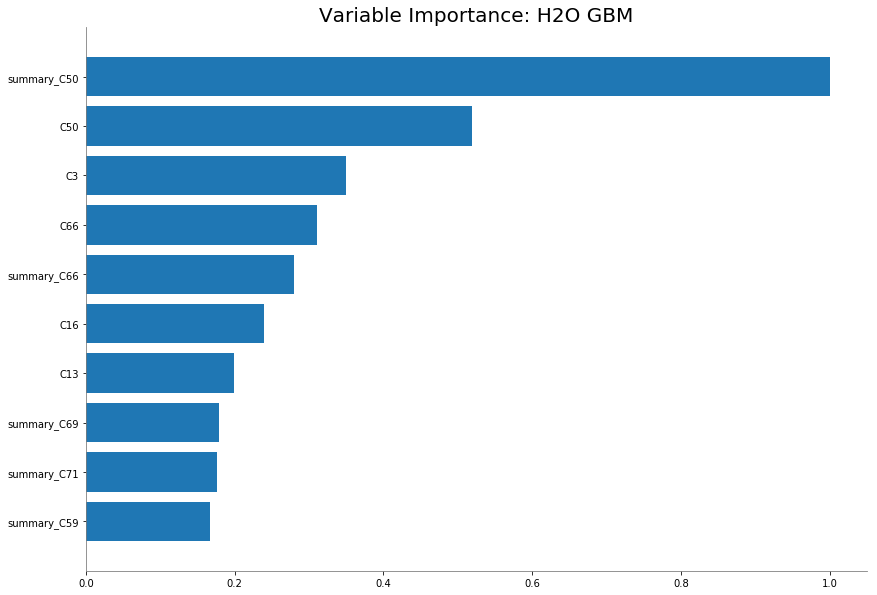

In [66]:
gbm_plus_summary.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


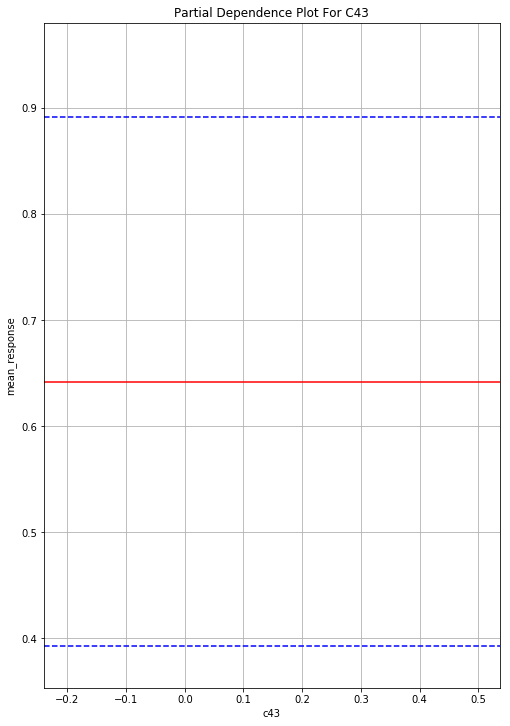

In [67]:
pdp_word_vecs = gbm_plus_summary.partial_plot(data = ext_train, cols = ["C43"])

- We can see that a low `C43` is associated with a smaller probability of positive review-'Negative'.  
- Let's see what words have a low `C43` value.

In [68]:
# Get Word Embeddings per Word
unique_words = words.asfactor().unique().ascharacter()
unique_words.col_names = ["Word"]

word_embeddings = w2v_model.transform(unique_words, aggregate_method="None")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~(word_embeddings["C1"].isna())]

/Users/bear/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


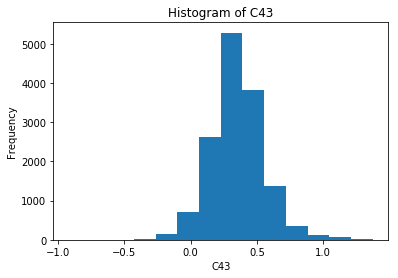

In [69]:
word_embeddings["C43"].hist()

In [70]:
low_c43_words = word_embeddings[word_embeddings["C43"] < -1.1]
low_c43_words[["Word", "C43"]].head(15)

Word,C43
www,-1.16458


- The words with low `C43` like `contacted`, `answered`, `emails`, `phone` and `refund` all seem to be related to contacting for a refund.  
- Words like: `salmonella` are obviously an indicator of a negative review for a food product.

## Predict on New Reviews

Now that we've built a model we are satisifed with, we will see how the model performs on new reviews.

* *"The taste is great! especially when you cook it with some vegetable and egg. I like it very much, though it's more expensive than the other noodles"*


* *"Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."*

In [71]:
def predict(reviews, w2v, gbm):
    
    words = tokenize(reviews["Text"].ascharacter())
    reviews_vec = w2v.transform(words, aggregate_method="AVERAGE")
    
    summary_words = tokenize(reviews["Summary"].ascharacter())
    summary_vec = w2v.transform(summary_words, aggregate_method="AVERAGE")
    
    model_data = reviews.cbind(reviews_vec).cbind(summary_vec)
    print(gbm.predict(model_data))

In [72]:
good_review = h2o.H2OFrame([["B000EQT574", "AISQLBDGS2KXR", 1, 1, 1263340800, 
                             "Delicious",
                             "These chips are delicious. Salty sweet with a hint of spice. I have no idea how Tamari is supposed to taste, but these chips are awesome. I just finished an entire bag in one day!"]])

good_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [73]:
bad_review = h2o.H2OFrame([["B003BJZMSM", "A2JBZHQVQF7MV0", 1, 2, 1274832000, 
                            "Pretty tasteless",
                            "Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."]])

bad_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [74]:
# Predict!
print("Good Review: ")
print(predict(good_review, w2v_model, gbm_embeddings))

print("Bad Review: ")
print(predict(bad_review, w2v_model, gbm_embeddings))

Good Review: 
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.32358,0.67642



None
Bad Review: 
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.90481,0.0951898



None


In [75]:
h2o.cluster().shutdown()

H2O session _sid_a47a closed.
